# Classification

## Import Libraries

In [2]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
import matplotlib as mpl

%matplotlib inline

## Get and View Data

In [3]:
mnist = fetch_openml('mnist_784', version = 1)

In [5]:
X, y = mnist['data'],mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

In [6]:
X = np.asarray(X)

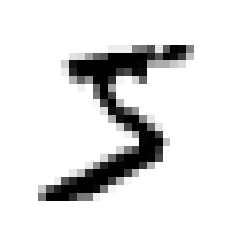

In [7]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.show()

In [8]:
y = y.astype(np.uint8)

In [9]:
X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

In [19]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, threshold=None):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], 'g--', label = "Recall")
    if threshold!=None:
        plt.axvline(threshold)
        index = (np.abs(thresholds - threshold)).argmin()
        plt.axhline(precisions[index])
        plt.axhline(recalls[index])
    plt.title('Precision and Recall vs Threshold Curves')
    plt.xlabel('Threshold')
    plt.legend(loc = 'upper left')
    plt.grid()

In [20]:
def plot_precision_vs_recall(precisions, recalls, recall_val = None):
    plt.plot(recalls, precisions, "b--")
    plt.title('Precision vs Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid()
    if recall_val!=None:
        plt.axvline(recall_val)
        index = (np.abs(recalls - recall_val)).argmin()
        plt.axhline(precisions[index])

1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [{"n_neighbors":list(np.linspace(1, 10, 10, dtype = 'int')), "weights":["uniform","distance"]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv = 5, scoring='accuracy', return_train_score=True, verbose=4)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END n_neighbors=1, weights=uniform;, score=(train=1.000, test=0.970) total time=   9.7s
[CV 2/5] END n_neighbors=1, weights=uniform;, score=(train=1.000, test=0.971) total time=   9.3s
[CV 3/5] END n_neighbors=1, weights=uniform;, score=(train=1.000, test=0.969) total time=   9.1s
[CV 4/5] END n_neighbors=1, weights=uniform;, score=(train=1.000, test=0.969) total time=  10.1s
[CV 5/5] END n_neighbors=1, weights=uniform;, score=(train=1.000, test=0.968) total time=  10.3s
[CV 1/5] END n_neighbors=1, weights=distance;, score=(train=1.000, test=0.970) total time=  11.0s
[CV 2/5] END n_neighbors=1, weights=distance;, score=(train=1.000, test=0.971) total time=  10.6s
[CV 3/5] END n_neighbors=1, weights=distance;, score=(train=1.000, test=0.969) total time=  10.8s
[CV 4/5] END n_neighbors=1, weights=distance;, score=(train=1.000, test=0.969) total time=  11.5s
[CV 5/5] END n_neighbors=1, weights=distance;, score=(train=1

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'weights': ['uniform', 'distance']}],
             return_train_score=True, scoring='accuracy', verbose=4)

In [53]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [59]:
from sklearn.metrics import accuracy_score

y_test_pred = grid_search.best_estimator_.predict(X_test)
print(f"Accuracy of the model: {accuracy_score(y_test, y_test_pred)}")

Accuracy of the model: 0.9714


In [60]:
from sklearn.metrics import precision_score, recall_score

print(f"Precision of the model: {precision_score(y_test, y_test_pred, average = 'weighted')}")
print(f"Recall of the model: {recall_score(y_test, y_test_pred, average = 'weighted')}")

Precision of the model: 0.9715166824529755
Recall of the model: 0.9714


We've achieved the desired accuracy!

2. Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion.

In [45]:
class DataAugmentation():
    def __init__(self, num_pixels_to_shift = 1): # no *args or *kwargs
        self.num_pixels_to_shift = num_pixels_to_shift
    
    def shift(self, X, dir):
        X_img = X.reshape((-1, 28, 28))
        X_shift = np.zeros(shape = X_img.shape)
        num_pixels = self.num_pixels_to_shift
        if dir == 'up':
            X_shift[:,:-num_pixels,:] = X_img[:,num_pixels:,:]
        if dir == 'down':
            X_shift[:, num_pixels:, :] = X_img[:, :-num_pixels,:]
        if dir == 'left':
            X_shift[:,:,:-num_pixels] = X_img[:,:,num_pixels:]
        if dir == 'right':
            X_shift[:,:,num_pixels:] = X_img[:,:,:-num_pixels]
        return X_shift.reshape((-1, 784))

    def transform(self, X, y):
        X_left = self.shift(X,'left')
        X_right = self.shift(X,'right')
        X_up = self.shift(X,'up')
        X_down = self.shift(X,'down')
        
        X_aug = np.concatenate((X,X_left,X_right,X_up, X_down), axis = 0)
        y_aug = np.r_[y,y,y,y,y]
        return X_aug, y_aug

In [50]:
augment_data = DataAugmentation(2)
X_aug_train, y_aug_train = augment_data.transform(X_train, y_train)

Shuffle the data since now there's a pattern in the data which we would want to avoid.

In [52]:
idx = np.random.permutation(len(X_aug_train))
X_aug_train, y_aug_train = X_aug_train[idx], y_aug_train[idx]

In [54]:
knn_clf = KNeighborsClassifier(n_neighbors=4, weights = 'distance')
knn_clf.fit(X_aug_train, y_aug_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [61]:
y_test_pred = knn_clf.predict(X_test)
print(f"Accuracy of the model: {accuracy_score(y_test, y_test_pred)}")

Accuracy of the model: 0.9706


In [62]:
print(f"Precision of the augmented model: {precision_score(y_test, y_test_pred, average = 'weighted')}")
print(f"Recall of the augmented model: {recall_score(y_test, y_test_pred, average = 'weighted')}")

Precision of the augmented model: 0.9709064779080727
Recall of the augmented model: 0.9706


3. Tackle the Titanic dataset. A great place to start is on Kaggle.

In [7]:
import os
os.environ['KAGGLE_USERNAME'] = 'pratiksangh'
os.environ['KAGGLE_KEY'] = '6541dd1b65a4da0f34d6543acd72b548'
!kaggle competitions download -c titanic


  0%|          | 0.00/34.1k [00:00<?, ?B/s]
100%|██████████| 34.1k/34.1k [00:00<00:00, 4.36MB/s]


### Extract and remove the zipped file

In [3]:
import zipfile

with zipfile.ZipFile('titanic.zip','r') as zip_ref:
    zip_ref.extractall('./datasets/titanic')

if os.path.exists('./datasets/titanic/train.csv'):
    os.remove('titanic.zip')

### Read Data

In [1]:
import pandas as pd

train_dataset = pd.read_csv('./datasets/titanic/train.csv')
test_dataset = pd.read_csv('./datasets/titanic/test.csv')

### Transform and Prepare Data

In [2]:
corr_matrix = train_dataset.corr()
corr_matrix['Survived'].sort_values(ascending = False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

In [3]:
from sklearn.impute import SimpleImputer

In [4]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
dataset_num = train_dataset.drop(["PassengerId","Survived","Pclass","Name","Sex", "SibSp","Parch","Ticket", "Cabin", "Embarked"], axis = 1)

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())
])

In [8]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('one_hot_encoder', OneHotEncoder())
])

In [9]:
from sklearn.compose import ColumnTransformer

num_attribs = list(dataset_num.columns)
cat_attribs = ["Pclass","Sex", "SibSp","Parch", "Embarked"]

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

dataset = pd.concat([train_dataset, test_dataset])
dataset_prepared = full_pipeline.fit_transform(dataset)
train_dataset_prepared = full_pipeline.transform(train_dataset)

In [10]:
test_dataset_prepared = full_pipeline.transform(test_dataset)

In [11]:
train_labels = train_dataset['Survived'].copy()

### Read the Test Labels

In [13]:
test_labels = pd.read_csv('./datasets/titanic/gender_submission.csv')

### Trying out different Models

In [14]:
# 1. Support Vector Classifier
from sklearn.svm import SVC

# 2. Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# 3. K Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

In [15]:
# Getting the accuracy score metric to decide which model to choose.
from sklearn.metrics import accuracy_score

In [16]:
svc_clf = SVC()
svc_clf.fit(train_dataset_prepared, train_labels)

SVC()

In [22]:
test_labels_pred = svc_clf.predict(test_dataset_prepared)
print(f'Accuracy over test set: {accuracy_score(test_labels["Survived"], test_labels_pred)}')

Accuracy over test set: 0.9354066985645934


In [23]:
forest_clf = RandomForestClassifier()
forest_clf.fit(train_dataset_prepared, train_labels)

RandomForestClassifier()

In [24]:
test_labels_pred = forest_clf.predict(test_dataset_prepared)
print(f'Accuracy over test set: {accuracy_score(test_labels["Survived"], test_labels_pred)}')

Accuracy over test set: 0.80622009569378


In [25]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(train_dataset_prepared, train_labels)

KNeighborsClassifier()

In [26]:
test_labels_pred = knn_clf.predict(test_dataset_prepared)
print(f'Accuracy over test set: {accuracy_score(test_labels["Survived"], test_labels_pred)}')

Accuracy over test set: 0.8564593301435407


So it appears that SVC performs the best for the given dataset! Lets tune the hyperparameters to see if it improves the performance.

In [29]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {"C":[1e-2,1e-1,1,1e1,1e2],"kernel":["linear"],"decision_function_shape":['ovo','ovr']},
    {"C":[1e-2,1e-1,1,1e1,1e2],"kernel":["poly", "rbf","sigmoid"],"gamma":["scale", "auto"],"decision_function_shape":['ovo','ovr']}
]

svc_clf = SVC()
grid_search = GridSearchCV(svc_clf, param_grid, cv = 5, scoring='accuracy', return_train_score=True, verbose=4)

grid_search.fit(train_dataset_prepared, train_labels)

Fitting 5 folds for each of 70 candidates, totalling 350 fits
[CV 1/5] END C=0.01, decision_function_shape=ovo, kernel=linear;, score=(train=0.782, test=0.793) total time=   0.0s
[CV 2/5] END C=0.01, decision_function_shape=ovo, kernel=linear;, score=(train=0.785, test=0.803) total time=   0.0s
[CV 3/5] END C=0.01, decision_function_shape=ovo, kernel=linear;, score=(train=0.790, test=0.787) total time=   0.0s
[CV 4/5] END C=0.01, decision_function_shape=ovo, kernel=linear;, score=(train=0.795, test=0.753) total time=   0.0s
[CV 5/5] END C=0.01, decision_function_shape=ovo, kernel=linear;, score=(train=0.787, test=0.787) total time=   0.0s
[CV 1/5] END C=0.01, decision_function_shape=ovr, kernel=linear;, score=(train=0.782, test=0.793) total time=   0.0s
[CV 2/5] END C=0.01, decision_function_shape=ovr, kernel=linear;, score=(train=0.785, test=0.803) total time=   0.0s
[CV 3/5] END C=0.01, decision_function_shape=ovr, kernel=linear;, score=(train=0.790, test=0.787) total time=   0.0s
[C

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [0.01, 0.1, 1, 10.0, 100.0],
                          'decision_function_shape': ['ovo', 'ovr'],
                          'kernel': ['linear']},
                         {'C': [0.01, 0.1, 1, 10.0, 100.0],
                          'decision_function_shape': ['ovo', 'ovr'],
                          'gamma': ['scale', 'auto'],
                          'kernel': ['poly', 'rbf', 'sigmoid']}],
             return_train_score=True, scoring='accuracy', verbose=4)

In [30]:
grid_search.best_params_

{'C': 10.0, 'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'rbf'}

In [31]:
test_labels_pred = grid_search.best_estimator_.predict(test_dataset_prepared)
print(f'Accuracy over test set: {accuracy_score(test_labels["Survived"], test_labels_pred)}')

Accuracy over test set: 0.9354066985645934


So seems like we're at the minima for support vector classifier. But this was a good exercise anyway to check if there existed further scope for optimisation. As a last check, let us compute the precision, recall and f1 score for the model.

In [35]:
from sklearn.metrics import precision_score, recall_score,f1_score

print(f"Precision of the model: {precision_score(test_labels['Survived'], test_labels_pred)}")
print(f"Recall of the model: {recall_score(test_labels['Survived'], test_labels_pred)}")
print(f"F1 Score of the model: {f1_score(test_labels['Survived'], test_labels_pred)}")

Precision of the model: 0.9432624113475178
Recall of the model: 0.875
F1 Score of the model: 0.9078498293515359


Seems decent enough!

In [36]:
df_submission = pd.DataFrame({'PassengerId':test_labels["PassengerId"].to_list(), 'Survived':test_labels_pred})
df_submission.to_csv('./datasets/titanic/submission.csv', index = False)

In [37]:
!kaggle competitions submit -c titanic -f ./datasets/titanic/submission.csv -m "Model: `SVC Model`, Params: `{'C': 10.0, 'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'rbf'}`,Accuracy: 0.9354066985645934, Precision: 0.9432624113475178, Recall: 0.875, F1 Score: 0.9078498293515359"

Successfully submitted to Titanic - Machine Learning from Disaster



  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|██████████| 3.18k/3.18k [00:00<00:00, 20.9kB/s]
100%|██████████| 3.18k/3.18k [00:05<00:00, 634B/s]  


4. Build a spam classifier (a more challenging exercise):
    * Download examples of spam and ham from Apache SpamAssassin’s public datasets.
    * Unzip the datasets and familiarize yourself with the data format.
    * Split the datasets into a training set and a test set.
    * Write a data preparation pipeline to convert each email into a feature vector. Your preparation pipeline should transform an email into a (sparse) vector that indicates the presence or absence of each possible word. For example, if all emails only ever contain four words, “Hello,” “how,” “are,” “you,” then the email “Hello you Hello Hello you” would be converted into a vector [1, 0, 0, 1] (meaning [“Hello” is present, “how” is absent, “are” is absent, “you” is present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of each word.<br>

You may want to add hyperparameters to your preparation pipeline to control whether or not to strip off email headers, convert each email to lowercase, remove punctuation, replace all URLs with “URL,” replace all numbers with “NUMBER,” or even perform stemming (i.e., trim off word endings; there are Python libraries available to do this). 

Finally, try out several classifiers and see if you can build a great spam classifier, with both high recall and high precision.

In [1]:
import tarfile
import urllib

In [11]:
def fetch_spam_data(ham_url, spam_url, spam_path):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", ham_url), ("spam.tar.bz2", spam_url)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=spam_path)
        tar_bz2_file.close()

In [12]:
ham_url = "https://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham.tar.bz2"
spam_url = "https://spamassassin.apache.org/old/publiccorpus/20021010_spam.tar.bz2"
spam_path = "./datasets/spam_dataset"

fetch_spam_data(ham_url, spam_url, spam_path)

Now here's something I don't know yet so we'll be taking a small nudge from the solution notebook. Sometimes, to push forward we need inspiration and the courage to recognise our limitations!

In [1]:
import email
import email.policy

def load_email(path_to_email):
    with open(path_to_email,"rb") as email_file:
        return email.message_from_binary_file(email_file, policy=email.policy.default)

So now lets construct a list of ham and spam emails with the above function.

In [2]:
ham_emails = [load_email(f'./datasets/spam_dataset/easy_ham/{email_file}') for email_file in os.listdir('./datasets/spam_dataset/easy_ham')]
spam_emails = [load_email(f'./datasets/spam_dataset/spam/{email_file}') for email_file in os.listdir('./datasets/spam_dataset/spam')]

len(ham_emails), len(spam_emails)

(2551, 501)

Some emails are actually multipart with their own attachments which in turn could have their own attachments.

In [3]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([get_email_structure(sub_email) for sub_email in payload]))
    else:
        return email.get_content_type()

In [4]:
from collections import Counter

def structures_counter(emails):
    structures_count = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures_count[structure] += 1
    return structures_count

In [5]:
structures_counter(ham_emails).most_common()

[('text/plain', 2453),
 ('multipart(text/plain, application/pgp-signature)', 72),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [6]:
structures_counter(spam_emails).most_common()

[('text/plain', 222),
 ('text/html', 181),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 19),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

We see a lot more html type emails! One more important step in cleaning will be to clean out the html type emails for which we need to define a function. On the agenda will be:
1. Remove all `<head>` type tags
2. Replace `<a>` with ' HYPERLINK '
3. Remove any other tag
4. Remove extra spaces, carriage returns, empty lines
5. Remove html entities such as `&gt;`, `&nbsp;`

In [7]:
import re
from html import unescape
import unicodedata

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

Before we do preprocessing, let us first construct our train and test sets

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype = object)
y = np.array([0]*len(ham_emails)+[1]*len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [9]:
def email_to_text(email):
    content = ""
    for part in email.walk():
        if part.get_content_type() not in ["text/plain","text/html"]:
            continue
        try:
            part_content = part.get_content()
        except: # encoding error
            part_content = str(part.get_payload())
        if part.get_content_type() == "text/plain":
            content += part_content
        else:
            content += html_to_plain_text(part_content)
    
    return content

As instructed in the problem statement, we need to get the word stem from the individual words to reduce the sparsity of the train data. For this we will use the nltk (Natural Language Toolkit)

In [10]:
import nltk
import urlextract
stemmer = nltk.PorterStemmer()

We also want to 
1. Replace all URLs in the text data with "URL"
2. Might want to convert data to lower case
3. Replace numerical data with "NUMBER"

Let us now give final shape to the transformer that will form the first step of our Transformation Pipeline.

In [11]:
from sklearn.base import TransformerMixin, BaseEstimator

class EmailToWordCounter(TransformerMixin, BaseEstimator):
    def __init__(self, strip_header = True, lower_case = True, remove_punctuations = True, replace_urls = True, replace_numbers = True, stemming = True):
        self.strip_header = strip_header
        self.lower_case = lower_case
        self.remove_punctuations = remove_punctuations
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming

    def fit(self, X, y = None):
        return self

    def html_to_plain_text(self, html_data):
        """
        Objectives:
        1. Remove headers if strip_header is True
        2. Remove 'a' tags and replace with "HYPERLINK"
        3. Remove all other tags
        4. Replace extra whitespaces, newlines
        5. Replace escape characters in html such as '&gt;','&nbsp;'
        """
        if self.strip_header == True:
            text = re.sub('<head.*?>.*?</head>','',html_data, flags = re.M | re.S | re.I)
        else:
            text = html_data
        text = re.sub('<a\s.*?>',' HYPERLINK ', text, flags = re.M | re.S | re.I)
        text = re.sub('<.*?>', '', text, flags=re.M | re.S)
        text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
        return unescape(text)
    
    def email_to_text(self, email):
        content = ""
        for part in email.walk():
            if part.get_content_type() not in ["text/plain","text/html"]:
                continue
            try:
                part_content = part.get_content()
            except:
                part_content = str(part.get_payload())
            if part.get_content_type() == "text/plain":
                content += part_content
            else:
                content += self.html_to_plain_text(part_content)
        
        return content

    def transform(self, X, y = None):
        X_transformed = []
        for email in X:
            # Convert to plain text
            text = self.email_to_text(email)

            # Convert to lower case if specified
            if self.lower_case:
                text = text.lower()

            # Replace URLs if specified
            if self.replace_urls:
                url_extractor = urlextract.URLExtract()
                urls = list(set(url_extractor.find_urls(text)))
                for url in urls:
                    text = text.replace(url, " URL ")
            
            # Replace numbers by keyword if specified
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)

            # Remove punctuations if needed
            if self.remove_punctuations:
                text = re.sub(r'\W+',' ',text, flags = re.M)
                text = text.replace("_", "")

            # Create a counter of words
            word_counts = Counter(text.split())

            # If stemming is specified then get word stem and create a modified counter
            if self.stemming:
                stemmed_word_counts = Counter()
                stemmer = nltk.PorterStemmer()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += 1
                word_counts = stemmed_word_counts
            
            # Append transformed sequence to result array
            X_transformed.append(word_counts)
        
        return np.array(X_transformed)


In [40]:
X_in = X_train[:3]
X_in_word_counts = EmailToWordCounter().fit_transform(X_in)
X_in_word_counts

array([Counter({'pay': 2, 'look': 2, 'if': 1, 'the': 1, 'creator': 1, 'didnt': 1, 'say': 1, 'you': 1, 'could': 1, 'have': 1, 'it': 1, 'without': 1, 's': 1, 'theft': 1, 'so': 1, 'simpl': 1, 'hell': 1, 'that': 1, 'even': 1, 'in': 1, 'all': 1, 'major': 1, 'holi': 1, 'book': 1, 'wow': 1, 'i': 1, 've': 1, 'got': 1, 'a': 1, 'great': 1, 'idea': 1, 'll': 1, 'hire': 1, 'skywrit': 1, 'to': 1, 'write': 1, 'can': 1, 't': 1, 'at': 1, 'thi': 1, 'then': 1, 'lock': 1, 'up': 1, 'everybodi': 1, 'who': 1, 'and': 1, 'didn': 1, 'fail': 1, 'jesu': 1, 'is': 1, 'on': 1, 'my': 1, 'side': 1, 'url': 1}),
       Counter({'look': 2, 'date': 1, 'tue': 1, 'number': 1, 'aug': 1, 'from': 1, 'brent': 1, 'welch': 1, 'panasa': 1, 'com': 1, 'messag': 1, 'id': 1, 'numbervaanumb': 1, 'blackcomb': 1, 'if': 1, 'we': 1, 'are': 1, 'allow': 1, 'to': 1, 'assum': 1, 'or': 1, 'higher': 1, 'which': 1, 'can': 1, 't': 1, 'realli': 1, 'then': 1, 'could': 1, 'add': 1, 'the': 1, 'selecttypein': 1, 'procedur': 1, 'ye': 1, 'i': 1, 'at': 1,

Now we need to convert these to vectors that we can train our model on. For this we define the following class

In [47]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, vocabulary_length = 1000):
        self.vocabulary_length = vocabulary_length

    def fit(self, X, y = None):
        """
        Get total word count and then pick the most commonly occurring words upto vocabulary length specified and then take those in vocabulary
        We set the vocabulary here because the vocabulary shouldn't change between the train and test set. So we will fit_transform on train data
        and transform on test data
        """
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += count
        most_common = total_count.most_common()[:self.vocabulary_length]
        self.vocabulary_ = {word:index + 1 for index, (word, count) in enumerate(most_common)}
        return self

    def transform(self, X, y = None):
        """
        Here we want to construct a matrix of counts of each vocabulary word. 
        For this we're using the `csr_matrix` method of scipy
        csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
        """
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                # capture row corresponding to the current word
                rows.append(row)
                # capture column in the row corresponding to the current word
                # if word is not in vocabulary, it will go to the first index
                cols.append(self.vocabulary_.get(word, 0))
                # capture the count of the word in the email
                # this is essentially what we want to train over
                data.append(count)
        
        return csr_matrix((data, (rows, cols)), shape = (len(X), self.vocabulary_length + 1))

In [48]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_length = 50)
X_vocab_trans = vocab_transformer.fit_transform(X_in_word_counts)
X_vocab_trans

<3x51 sparse matrix of type '<class 'numpy.intc'>'
	with 90 stored elements in Compressed Sparse Row format>

So seems to be working perfectly!

In [49]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ('email_to_word_counter', EmailToWordCounter()),
    ('word_counter_to_vector', WordCounterToVectorTransformer())
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [50]:
X_test_transformed = preprocess_pipeline.transform(X_test)

In [54]:
import sklearn
knn_clf = sklearn.neighbors.KNeighborsClassifier(n_jobs = -1)
knn_clf.fit(X_train_transformed, y_train)

KNeighborsClassifier(n_jobs=-1)

In [55]:
from sklearn.metrics import accuracy_score
y_test_pred = knn_clf.predict(X_test_transformed)
print(f"Accuracy of the classifier: {accuracy_score(y_test, y_test_pred)}")

Accuracy of the classifier: 0.8477905073649754


We have an accuracy of ~85%. This isn't bad for our first try!